# Homework 6: Predicting Housing Prices

### Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the homework, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** at the top of your solution.

## Due Date: 11:59pm Tuesday, April 10

## Introduction
In this homework, we will go through the iterative process of specifying, fitting, and refining a model.  

In the first portion of the assignment, we will guide you through some basic EDA, laying out the thought process that leads to certain modeling decisions.  We will then specify and fit two linear models, providing an example of the type of code we expect from you in the open-response.

The second part of the assignment is purposefully left open-ended.  You will be allowed to build a linear model of your choice to compete against your peers in an in-class Kaggle competition.  **DO NOT PUT THIS ASSIGNMENT OFF TO THE LAST MOMENT AS THERE IS A CAP ON DAILY KAGGLE SUBMISSIONS**

After this homework, you should feel comfortable with the following:

1. Working with a messy data set that requires a moderate amount of cleaning and wrangling
1. Using sklearn to build models
1. Using several different transformations on your data
1. Building a data pipeline using pandas
1. Using cross-validation for model selection

### You may find some standoffish empty cells with only a comment in them in this assignment.  They are there on purpose; please do not attempt to modify them.

## Score breakdown

Question | Points
--- | ---
[Question 1a](#q1a) | 5
[Question 1b](#q1b) | 5
[Question 2](#q2) | 6
[Question 3](#q3) | 6
[Question 4a](#q4a) | 3
[Question 4b](#q4b) | 3
[Question 5](#q5) | 6
[Question 6](#q6) | 6
[Question 7](#q7) | 6
[Question 8](#q8) | 6
[Question 9](#q9) | 6
[Question 10a](#q10a) | 3
[Question 10b](#q10b) | 3
[Question 11](#q11) | 6
[Question 12](#q12) | 25
[Question 13](#q13) | 5
Total | 100

## Short Proofs

#### Question 1 
We have data $(x_1, y_1) ... (x_n, y_n)$ drawn independently from the same distribution $P(x, y)$.  Our goal is to use a linear model to describe the relationship between $x$ and $y$.

$$ f_\theta(x) = \theta_1 + \theta_2 x $$

We fit $\hat{\theta}_1$ and $\hat{\theta}_2$ by minimizing average $L_2$ loss $$ \hat\theta = \text{argmin}_{\theta_1, \theta_2}\frac{1}{n}\sum_{i=1}^n (y_i - f_\theta(x_i))^2$$.

##### Part a <a name="q1a"></a>
The fitted/predicted y-values are given by:

$$ \hat{y}_i = f_\hat\theta(x_i) = \hat\theta_1 + \hat\theta_2 x_i $$

The **residuals** are defined as:

$$ e_i = \text{observed } y_i - \text{predicted } y_i = y_i - \hat y_i $$

Show that the sum of the residuals is equal to 0.  In other words, prove that

$$\sum_{i=1}^n e_i = 0$$

### Part a Answer
$\frac{\partial L}{\partial \hat \theta_1} = -\frac{2}{n}\sum_{i=1}^n (y_i - (\theta_1 + \theta_2 x_i))$

$\frac{\partial L}{\partial \hat \theta_2}$ = $-\frac{2}{n}\sum_{i=1}^n x_i(y_i - (\theta_1 + \theta_2 xi))$

Given that $\frac{\partial L}{\partial \hat \theta_1} = \frac{\partial L}{\partial \hat \theta_2} = 0$,

$ \sum_{i=1}^n (y_i - (\theta_1 + \theta_2 x_i)) = \sum_{i=1}^n y_i - (\sum_{i=1}^n \theta_1 + \theta_2 x_i) = 0$

Thus:

$ \sum_{i=1}^n (y_i - \hat y_i) = \sum_{i=1}^n e_i = 0$

#### Part b <a name="q1b"></a>

You can **center** a variable by subtracting the global mean of the variable from each observation:

In other words, for each $x_i$, you subtract off $\bar{x} = \frac{1}{n}\sum_{j=1}^n x_j$:

$$ x^{centered}_i = x_i - \bar{x} $$

Let $y_1, ..., y_n$ and $x_1, ..., x_n$ be centered training data.  Again, we want to fit a linear model.

$$ {y}_i = f_\theta(x_i) = \theta_1 + \theta_2 x_i $$

Show that $\hat\theta_1 = 0$ minimizes average $L_2$ loss on the training data.

### Part b Answer

$L_2 = \frac{1}{n}\sum_{i=1}^n (y^{centered} - f_\theta{x_i^{centered}})^2 = \frac{1}{n}\sum_{i=1}^n (y^{centered} - (\theta_1 + \theta_2(x_i^{centered}))^2 = \frac{1}{n}\sum_{i=1}^n (y_i - \hat y - (\theta_1 + \theta_2(x_i - \hat x))^2$

$\frac{\partial L}{\partial \theta_1} = -\frac{2}{n}\sum_{i=1}^n (y_i - \hat y - (\theta_1 + \theta_2(x_i - \hat x)) = -\frac{2}{n}\sum_{i=1}^n y_i - \sum_{i=1}^n\hat y - (\sum_{i=1}^n\theta_1 - \sum_{i=1}^n\theta_2 x_i - \sum_{i=1}^n\theta_2 \hat x)) = - \frac{2}{n} (0 - n\theta_1 - 0) = 2\theta_1$

$\frac{\partial L}{\partial \hat \theta_1} = 0$

$\hat \theta_1 = 0$

In [2]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

In [3]:
from sklearn.linear_model import Ridge
from sklearn import ensemble
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC

# The Data

The Ames data set consists of 2930 records taken from the Ames Assessor’s Office.  The data set has 23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables (and 2 additional observation identifiers) --- 82 features in total.  An explanation of each variable can be found in the included `codebook.txt` file.  The information was used in computing assessed values for individual residential properties sold in Ames, Iowa from 2006 to 2010.  **Some noise has been added to the actual sale price, so prices will not match official records.**

The data are split into training and test sets with 2000 and 930 observations, respectively.  The actual sale price is withheld from you in the test set.  In addition, the test data are further split into public and private test sets.  When you upload a test set prediction onto Kaggle for validation, the score you receive will be calculated using the public test set.  The private test set will be used in a final evaluation of this homework assignment.

In [4]:
training_data = pd.read_csv("ames_train.csv")
test_data = pd.read_csv("ames_test.csv")

As a good sanity check, we should at least verify that the data shape matches the description.

In [5]:
# 2000 observations and 82 features in training data
assert training_data.shape == (2000, 82)
# 930 observations and 81 features in test data
assert test_data.shape == (930, 81)
# SalePrice is hidden in the test data
assert 'SalePrice' not in test_data.columns.values
# Every other column in the test data should be in the training data
assert len(np.intersect1d(test_data.columns.values, 
                          training_data.columns.values)) == 81

The next order of business is getting a feel for the variables in our data.  The Ames data set contains information that typical homebuyers would want to know.  A more detailed description of each variable is included in `codebook.txt`.  **You should take some time to familiarize yourself with the codebook before moving forward.**

In [6]:
training_data.columns.values

array(['Order', 'PID', 'MS_SubClass', 'MS_Zoning', 'Lot_Frontage',
       'Lot_Area', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour',
       'Utilities', 'Lot_Config', 'Land_Slope', 'Neighborhood',
       'Condition_1', 'Condition_2', 'Bldg_Type', 'House_Style',
       'Overall_Qual', 'Overall_Cond', 'Year_Built', 'Year_Remod/Add',
       'Roof_Style', 'Roof_Matl', 'Exterior_1st', 'Exterior_2nd',
       'Mas_Vnr_Type', 'Mas_Vnr_Area', 'Exter_Qual', 'Exter_Cond',
       'Foundation', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure',
       'BsmtFin_Type_1', 'BsmtFin_SF_1', 'BsmtFin_Type_2', 'BsmtFin_SF_2',
       'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'Heating', 'Heating_QC',
       'Central_Air', 'Electrical', '1st_Flr_SF', '2nd_Flr_SF',
       'Low_Qual_Fin_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath',
       'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr',
       'Kitchen_AbvGr', 'Kitchen_Qual', 'TotRms_AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace_Qu', 'Garage_Type', 'Garage_Yr_Blt',

# Guided Modeling

In the first portion of the assignment, we will take you step-by-step through one cycle of the modeling process.  Along the way, we will provide commentary to give you a sense of the thought process that goes into building a model.

## EDA
Naturally, the first thing we want to do is get a feel for our data.  In this section, we will make a series of exploratory visualizations.  The plots we ask you to reproduce here are far from exhaustive.  **When you build your own model in the second part of this assignment, you will want to delve deeper into the data.**

Note that we will perform EDA on the **training data** so that information from the test data does not influence our modeling decisions.

### Sale Price
We begin by examining a [raincloud plot](https://micahallen.org/2018/03/15/introducing-raincloud-plots/amp/?__twitter_impression=true) (yet another name for a combination of a KDE, a boxplot, and a boxplot all-in-one) of our target variable `SalePrice`.  At the same time, we also take a look at some descriptive statistics of this variable.

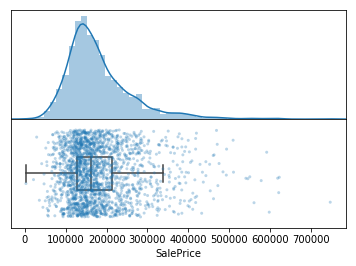

In [7]:
fig, axs = plt.subplots(nrows=2)

sns.distplot(
    training_data['SalePrice'], 
    ax=axs[0]
)
sns.stripplot(
    training_data['SalePrice'], 
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    training_data['SalePrice'],
    width=0.3, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(training_data['SalePrice']) * 0.05
xmin = np.min(training_data['SalePrice']) - spacer
xmax = np.max(training_data['SalePrice']) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
axs[1].artists[0].set_facecolor('white')

In [8]:
training_data['SalePrice'].describe()

count      2000.000000
mean     180775.897500
std       81581.671741
min        2489.000000
25%      128600.000000
50%      162000.000000
75%      213125.000000
max      747800.000000
Name: SalePrice, dtype: float64

#### Question 2 <a name="q2"></a>
To check your understanding of the graph and summary statistics above, answer the following `True` or `False` questions:

1. The distribution of `SalePrice` in the training set is left-skew.
1. The mean of `SalePrice` in the training set is greater than the median.
1. 75% of the houses in the training set sold for less than \$213,125.00.

In [9]:
# These should be True or False
q1statement1 = False
q1statement2 = True
q1statement3 = True



In [10]:
# Two of these statements are True.
assert sum([q1statement1, q1statement2, q1statement3]) == 2

In [11]:
# Yes, this is a cell with just a comment.

### SalePrice vs Gr_Liv_Area

Next, we examine `SalePrice` vs `Gr_Liv_Area`.  Now it's not entirely obvious what `Gr_Liv_Area` should be, so we'll need to consult `codebook.txt`.  We find:

```
Gr Liv Area (Continuous): Above grade (ground) living area square feet
```

Ok, so this variable represents the square footage of the house excluding anything built underground.  Some additional research (into real estate conventions) reveals that this value also excludes the garage space.

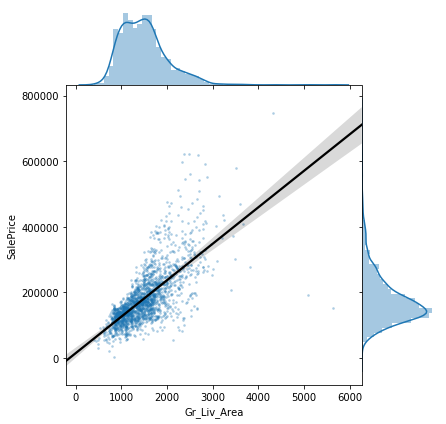

In [12]:
sns.jointplot(
    x='Gr_Liv_Area', 
    y='SalePrice', 
    data=training_data,
    stat_func=None,
    kind="reg",
    ratio=4,
    space=0,
    scatter_kws={
        's': 3,
        'alpha': 0.25
    },
    line_kws={
        'color': 'black'
    }
)

We notice that there is a plausible linear relationship between house size and sale price, but the spread is wider at larger sale prices and above grade living areas.  There seem to be two particularly suspicious houses above 5000 square feet.

#### Question 3 <a name="q3"></a>
What are the Parcel Indentification Numbers for the two houses with `Gr_Liv_Area` greater than 5000 sqft?

In [13]:
training_data[training_data["Gr_Liv_Area"] > 5000]

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
1014,1499,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,152200
1471,2181,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,...,0,NaN,NaN,Elev,17000,10,2007,New,Partial,190950


In [14]:
# Hint: You can answer this question purely through pandas
# q2house1 and q2house2 should be integers
q2house1 = 908154235
q2house2 = 908154195

# YOUR CODE HERE

In [15]:
assert isinstance(q2house1, int)
assert isinstance(q2house2, int)

In [16]:
# Yes, this is a cell with just a comment. Watcha gonna do?

#### Question 4a <a name="q4a"></a>

The codebook actually tells us how to manually inspect the houses using an online database called Beacon. These two houses are true outliers in this data set.  They were partial sales that were priced much under market value.  We will remove them in the guided model, but perhaps you will want to address them differently in your own model.  To make sure you know how to view the online database, please answer the following question:

What are the gross values of the two houses with `Gr_Liv_Area` greater than 5000 as of 2017?  You will find this under the section titled "Valuation (Ames)".  Your answers should be integers.

In [17]:
q3house1 = 1169500
q3house2 = 1104100

# YOUR CODE HERE

In [18]:
# Make sure your answer is integer-valued
assert isinstance(q3house1, int)
assert isinstance(q2house2, int)

In [19]:
# Go away.

#### Question 4b <a name="q4b"></a>

Write a function `remove_outliers` that removes outliers from a data set based off a threshold value of a variable.  For example, `remove_outliers(training_data, 'Gr_Liv_Area', upper=5000)` should return a data frame with only observations that satisfy `Gr_Liv_Area` less than or equal to 5000.

In [20]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a winsorized data frame with outliers removed
    """
        
    df = data[data[variable] <= 5000]
    return df
    
training_data = remove_outliers(training_data, 'Gr_Liv_Area', upper=5000)

In [21]:
# Make sure that two observations were removed
assert training_data.shape[0] == 1998

In [22]:
# No admittance.  Except on party business.

### Neighborhood vs Sale Price

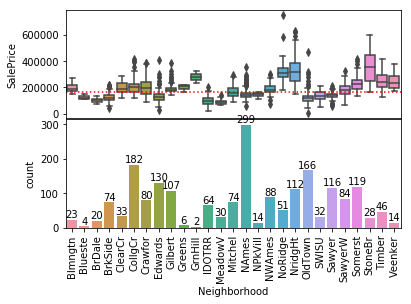

In [23]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x='Neighborhood',
    y='SalePrice',
    data=training_data.sort_values('Neighborhood'),
    ax=axs[0]
)

sns.countplot(
    x='Neighborhood',
    data=training_data.sort_values('Neighborhood'),
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y=training_data['SalePrice'].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.01)

From the plot above, it becomes clear that there is quite some variation in prices across neighborhoods.  Moreover, the amount of data available is not uniformly distributed among neighborhoods.  North Ames, for example, comprises almost 15% of the training data while Green Hill has a scant 2 observations in this data set.

One way we can deal with the lack of data from some neighborhoods is to create a new feature that bins neighborhoods together.  Let's dichotomize our neighborhoods in a very crude way: we'll take the top 3 neighborhoods measured by median `SalePrice` and identify them as "rich neighborhoods"; the other neighborhoods are not marked.

#### Question 5 <a name="q5"></a>

Write a function that returns list of the top n most pricy neighborhoods as measured by our choice of aggregating function.  For example, in the setup above, we would want to call `find_rich_neighborhoods(training_data, 3, np.median)` to find the top 3 neighborhoods measured by mdian `SalePrice`.

In [24]:
def find_rich_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (data frame): should contain at least a string-valued Neighborhood
        and a numeric SalePrice column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the top n richest neighborhoods as measured by the metric function
    """
    df = data.groupby('Neighborhood')[['SalePrice']].median().sort_values('SalePrice', ascending = False). reset_index().head(n)
    neighborhoods = df['Neighborhood'].tolist()
    return neighborhoods

rich_neighborhoods = find_rich_neighborhoods(training_data, 3, np.median)
rich_neighborhoods

['StoneBr', 'NridgHt', 'NoRidge']

In [25]:
# Check to see if the n argument works
assert len(find_rich_neighborhoods(training_data, 5, np.median)) == 5
assert isinstance(rich_neighborhoods, list)
# Check to see if the list contains only strings
assert all([isinstance(neighborhood, str) for neighborhood in rich_neighborhoods])

In [26]:
# Shoo.

## Missing Data

#### Question 6 <a name="q6"></a>
Let's see if our data set has any missing values.  Create a Series object containing the counts of missing values in each of the columns of our data set sorted from greatest to least.  The Series should be indexed by the variable names.  For example, `missing_counts['Fireplace_Qu']` should return 975.

In [27]:
def count_na(tbl, col_name):
    num = len(tbl[col_name]) - tbl[col_name].count()
    return num
na_list = []

for i in training_data.columns.values:
    na = count_na(training_data, i)
    na_list.append(na)

In [28]:
missing_counts = pd.Series(na_list, index =training_data.columns.values)

# YOUR CODE HERE

In [29]:
# Make sure your answer is a Series
assert isinstance(missing_counts, pd.Series)
# Make sure all columns are represented
assert missing_counts.size == 82
# Make sure your index values match column names
assert set(missing_counts.index.values) == set(training_data.columns.values)

In [30]:
# Well go on now.

It turns out that if we look at the codebook carefully, some of these "missing values" aren't missing at all! The Assessor's Office just used `NA` to denote a special value or that the information was truly not applicable for one reason or another.  One such example is the `Fireplace_Qu` variable.
```
FireplaceQu (Ordinal): Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace inbasement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
```

#### Question 7 <a name="q7"></a>

An `NA` here actually means that the house had no fireplace to rate.  Let's fix this in our data set.  Write a function that replaces the missing values in `Fireplace_Qu` with `'No Fireplace'`.  In addition, it should replace each abbreviated condition with its full word.  For example, `'TA'` should be changed to `'Average'`.  Hint: the [DataFrame.replace](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html) method may be useful here.


In [31]:
def fix_fireplace_qu(data):
    """
    Input:
      data (data frame): a data frame containing a Fireplace_Qu column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored Fireplace_Qu column
    """
    data['Fireplace_Qu'] = data['Fireplace_Qu'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], ['Excellent','Good','Average', 'Fair', 'Poor'])
    data['Fireplace_Qu'] = data['Fireplace_Qu'].fillna('No Fireplace')
    return data
    

    
training_data = fix_fireplace_qu(training_data)

In [32]:
# Make sure you've replaced all the missing values with 'No Fireplace'
assert sum(training_data['Fireplace_Qu'] == 'No Fireplace') == 975

In [33]:
# Bah humbug.

It turns out that simply fixing these missing values isn't sufficient for using `Fireplace_Qu` in our model.  Since `Fireplace_Qu` is a categorical/nominal variable, we will have to one-hot-encode the data.  Notice in the example code below that we have to pre-specify the categories.  Why? Imagine what would happen if we automatically generated the categories only from the training data.  What would happen if the testing data contained a category not found in the training set?  For more information on categorical data in pandas, refer to this [link](https://pandas-docs.github.io/pandas-docs-travis/categorical.html).  **Note that `get_dummies` removes the original column.**

In [34]:
def ohe_fireplace_qu(data):
    """
    One-hot-encodes fireplace quality.  New columns are of the form fpq_QUALITY
    """
    cats = [
        'Excellent',
        'Good',
        'Average',
        'Fair',
        'Poor',
        'No Fireplace'
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Fireplace_Qu'] = data['Fireplace_Qu'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='fpq',
                          columns=['Fireplace_Qu'], 
                          drop_first=True)
    
    return data

In [35]:
training_data = ohe_fireplace_qu(training_data)
training_data.filter(regex='fpq').head(10)

,fpq_Good,fpq_Average,fpq_Fair,fpq_Poor,fpq_No Fireplace
0,1,0,0,0,0
1,0,0,0,0,1
2,0,0,0,0,1
3,0,1,0,0,0
4,0,1,0,0,0
5,1,0,0,0,0
6,0,0,0,0,1
7,0,1,0,0,0
8,0,0,0,0,1
9,1,0,0,0,0


## Feature Engineering

In this section we will create a new feature out of existing ones through a simple data transformation.  When you move on to create your own model, you may want to try out more complex transformations.

### Bathrooms

We will create a groundbreaking new feature.  Due to recent advances in Universal WC Enumeration Theory, we now know that Total Bathrooms can be calculated as:

$$ TotalBathrooms=(BsmtFullBath + FullBath) + \dfrac{1}{2}(BsmtHalfBath + HalfBath)$$

The actual proof is beyond the scope of this class, but we will use the result in our model.
#### Question 8 <a name="q8"></a>

Write a function `add_total_bathrooms(data)` that returns the input data frame with a new column called `total_bathrooms` as calculated above.  **Treat missing values as 0s**.  Remember that you can make use of vectorized code here.

In [36]:
def add_total_bathrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least 4 numeric columns 
            Bsmt_Full_Bath, Full_Bath, Bsmt_Half_Bath, and Half_Bath
    Output:
      data frame identical to the input with the addition of a total_bathrooms column
    """
    
    data['Bsmt_Full_Bath'] = data.loc[:,'Bsmt_Full_Bath'].fillna(0)
    data['Full_Bath'] = data.loc[:,'Full_Bath'].fillna(0)
    data['Bsmt_Half_Bath'] = data.loc[:,'Bsmt_Half_Bath'].fillna(0)
    data['Half_Bath'] = data.loc[:,'Half_Bath'].fillna(0)
    data['total_bathrooms'] = data['Bsmt_Full_Bath'] + data['Full_Bath'] + 0.5 *(data['Bsmt_Half_Bath'] + data['Half_Bath'])
    return data

training_data = add_total_bathrooms(training_data)

In [37]:
# Check that missing values are dealt with
assert ~training_data['total_bathrooms'].isnull().any()
# Check that the values are as expected
assert training_data['total_bathrooms'].sum() == 4421.5

In [38]:
# **leers**

### Rich Neighborhoods

#### Question 9 <a name="q9"></a>
From before, we have a list of neighborhoods we've deemed as richer than others.  Let's use that information to make a new variable `in_rich_neighborhood`.  Write a function `add_rich_neighborhood` that adds an indicator variable which takes on the value 1 if the house is part of `rich_neighborhoods` (question 4) and the value 0 otherwise.

In [39]:
def add_in_rich_neighborhood(data, neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as rich
    Output:
      data frame identical to the input with the addition of a binary
      in_rich_neighborhood column
    """
    lst = data.loc[:,'Neighborhood'].tolist()
    i = 0
    indicator = []
    while i < len(lst):
        if lst[i] in neighborhoods:
            indicator.append(1)
        else:
            indicator.append(0)
        i += 1 
        
    data['in_rich_neighborhood'] = indicator
    return data

rich_neighborhoods = find_rich_neighborhoods(training_data, 3, np.median)
training_data = add_in_rich_neighborhood(training_data, rich_neighborhoods)

In [40]:
# Check to see if you have identified the correct number of rich neighborhoods
assert sum(training_data['in_rich_neighborhood']) == 191
# Check to see if you've introduced any missing values
assert sum(training_data['in_rich_neighborhood'].isnull()) == 0

In [41]:
# Repello Muggletum

## Modeling

We've finally gotten to a point where we can specify a simple model.  But first, we need to create perform a test-train split of our data.  We begin by loading a fresh copy of the data in at this point just in case our code above produced any undesired side-effects.  At this point, we will begin to treat `ames_train.csv` as our complete data set.  We will use `train_test_split` from `sklearn` to split the data into `test` and `train` sets.

Remember: The reason we have to do a train-test split on `ames_train.csv` here is because we want to evaluate how well our model might perform on future data (`ames_test.csv`), but that data set does not have `SalePrice` in it!

In [42]:
# Load a fresh copy of the data
full_data = pd.read_csv("ames_train.csv")

# This makes the train-test split in this section reproducible across different runs 
# of the notebook.  You do not need this line to run train_test_split in general
np.random.seed(1337) 

# Split the data 
train, test = train_test_split(full_data, test_size=0.2)

In [43]:
# Something has gone awry in the cell above if these do not pass
assert test.shape == (400, 82)
assert train.shape == (1600, 82)
assert train.loc[887, 'PID'] == 902402260

### Reusable Pipeline

Throughout this assignment, you should notice that your data flows through a single processing pipeline several times.  From a software engineering perspective, this should be sufficient motivation to abstract parts of our code into reusable functions/methods.  We will now encapsulate our entire pipeline into a single function `process_data_gm`.  gm is shorthand for "guided model".

In [44]:
def select_columns(data, *columns):
    return data.loc[:, columns]

def process_data_gm1(data):
    # Clean Data
    data = remove_outliers(data, 'Gr_Liv_Area', upper=5000)
    data = fix_fireplace_qu(data)
    
    # Transform Data
    data = add_total_bathrooms(data)
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'total_bathrooms',
                          'Fireplace_Qu',
                          'in_rich_neighborhood'
                         )
    data = ohe_fireplace_qu(data)
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data['SalePrice']
    
    return X, y

An alternative way of writing the same code above explicitly allows us to think about our data flowing through a [pipeline](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.pipe.html) where the output of one function is the input of the next.  Carefully thought out function names make the code self-documenting: you can just read off the intended high-level processing steps from top to bottom.

You are not required to use this style of coding.  We just wanted to point out that it exists.

In [45]:
def process_data_gm1(data):

    data = (
        data
        # Clean Data
        .pipe(remove_outliers, 'Gr_Liv_Area', upper=5000)
        .pipe(fix_fireplace_qu)
        
        # Transform data
        .pipe(add_total_bathrooms)
        .pipe(add_in_rich_neighborhood, rich_neighborhoods)
        .pipe(select_columns, 
              'SalePrice',           
              'Gr_Liv_Area',            
              'total_bathrooms',             
              'Fireplace_Qu',            
              'in_rich_neighborhood'
             )
        .pipe(ohe_fireplace_qu)
    ) 
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data['SalePrice']
    
    return X, y

### Fitting our first model

We are finally going to fit a model!  This part is slightly unceremonious since we did much of the heavy lifting in the previous sections.  The model we will fit can be written as follows (with the caveat that one of the fireplace qualities is actually removed to avoid collinearity):

$$\begin{align} SalePrice = &\theta_0 + \theta_1 \times GrLivArea + \theta_2 \times TotalBathrooms \\
&+ \theta_3 \times InRichNeighborhood + \sum_{quality \in FireplaceQuality} \theta_{quality} \times Quality
\end{align}$$

#### Question 10a <a name="q10a"></a>
Remove the commenting and fill in the ellipses `...` below with `X_train`, `y_train`, `X_test`, or `y_test`.

In [46]:
#sneaky
pd.set_option('mode.chained_assignment', None)

In [47]:
# Pre-process our training and test data in exactly the same way
# Our functions make this very easy!
X_train, y_train = process_data_gm1(train)
X_test, y_test = process_data_gm1(test)
guidedmodel1 = lm.LinearRegression(fit_intercept=True)

# Fill in the ... below with X_train, y_train, X_train, or X_test.
# Remember to uncomment
guidedmodel1.fit(X_train, y_train)
y_fitted = guidedmodel1.predict(X_train)
y_predicted = guidedmodel1.predict(X_test)


In [48]:
assert 181100 <= y_fitted.mean() <= 181400
assert 177700 <= y_predicted.mean() <= 177800

In this assignment, we will use Root-Mean-Square Error (RMSE) to measure the quality of our models.  As a reminder, this quantity is defined as:

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in test set}}(\text{actual price of house} - \text{predicted price of house})^2}{\text{# of houses in test set}}}$$

#### Question 10b <a name="q10b"></a>

Write a function `rmse` that calculates the RMSE of a model.  Again, make sure you are taking advantage of vectorized code.  This can be solved without any iteration.

In [49]:
def rmse(actual, predicted):
    """
    Calculates RMSE from actual and predicted values
    Input:
      actual (1D array-like): vector of actual values
      predicted (1D array-like): vector of predicted/fitted values
    Output:
      a float, the root-mean square error
    """
    
    rmse = np.sqrt(sum((actual - predicted)**2)/ 399)
    
    return rmse

In [50]:
assert 43000 <= rmse(y_test, y_predicted) <= 44000

### Residual Plots

One way of diagnosing a model is through a residual plot.  Here we plot the actual sale prices against the residuals of the model.  Ideally, we would see a horizontal line of points at 0 (perfect prediction!).  The next best thing would be a homogenous set of points centered at 0.  But alas, our simple model is probably too simple.  We notice that we are really underfitting the more expensive homes in the test set.  In fact, it looks like our model tends to underprice the more expensive homes!  You will probably want to address this in your own work.

Text(0,0.5,'Residuals (Actual Price - Predicted Price)')

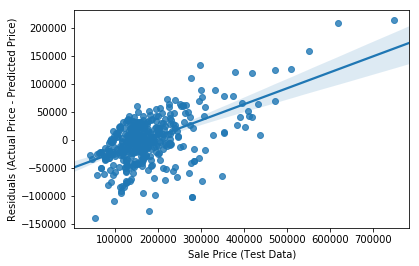

In [51]:
gm1_residuals = y_test - y_predicted
ax = sns.regplot(y_test, gm1_residuals)
ax.set_xlabel('Sale Price (Test Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')

### Regularizing our model

Ok, so let's make our modeling a little more fancy by regularizing the coefficients.  This second model will use the Lasso, but you are free to use Ridge or ElasticNet in your work.  First, we need to add a step to our pre-processing.  In order for regularization to be fair to all the variables in our model, we need to standardize our predictor columns (otherwise it would unfairly penalize variables with inherently small values).

#### Question 11 <a name="q11"></a>

Write a function that standardizes the columns of a data frame containing only numeric columns.  Be sure to make use of vectorization.

In [52]:
from sklearn import preprocessing

In [53]:
def standardize_columns(data):
    '''
    Input:
      data (data frame): contains only numeric columns
    Output:
      data frame, the same data, except each column is standardized 
      to have 0-mean and unit variance
    '''
    copy = data.copy()
    col = data.columns.values
    for i in col:
        copy[i] = preprocessing.scale(copy[i].astype('float64'))
    
    return copy

In [54]:
test_standardize_df = standardize_columns(training_data[['SalePrice', 'Gr_Liv_Area']])
# Make sure the mean is correct
assert -0.001 < test_standardize_df.mean().sum() < 0.001
# Make sure the standard deviation is correct
assert 1.9 < test_standardize_df.std().sum() < 2.1

We'll now use this function to describe our new processing for the regularized model.

In [55]:
def process_data_gm2(data):

    data = (
        data
        # Clean Data
        .pipe(remove_outliers, 'Gr_Liv_Area', upper=5000)
        .pipe(fix_fireplace_qu)
        
        # Transform data
        .pipe(add_total_bathrooms)
        .pipe(add_in_rich_neighborhood, rich_neighborhoods)
        .pipe(select_columns, 
              'SalePrice',           
              'Gr_Liv_Area',            
              'total_bathrooms',             
              'Fireplace_Qu',            
              'in_rich_neighborhood'
             )
        .pipe(ohe_fireplace_qu)
    ) 
    
    # Return predictor and response variables separately
    X = standardize_columns(data).drop(['SalePrice'], axis = 1)
    y = data['SalePrice']
    
    return X, y

It may be instructive to see the cross-validation procedure explicitly once.  You should be able to understand what each part of the code is doing below, but we do not expect you to use this code for your own model (use [LassoCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) instead).

In [56]:
# Process our data
X_train, y_train = process_data_gm2(train)
X_test, y_test = process_data_gm2(test)

# Specify our model
guidedmodel2 = lm.Lasso(copy_X=True)

# Specify CV method and alpha grid
five_fold_cv = KFold(n_splits = 5)
alphas = np.arange(0.1, 200.1, .1)
rmses = np.zeros(len(alphas))

# Grid search over alphas
for i, alpha in enumerate(alphas):
    guidedmodel2.set_params(alpha=alpha)
    model_rmse = 0
    
    # Fit each fold using the other four as training data
    for train_index, test_index in five_fold_cv.split(X_train):
        X_fold_train = X_train.iloc[train_index]
        y_fold_train = y_train.iloc[train_index]
        X_fold_test = X_train.iloc[test_index]
        y_fold_test = y_train.iloc[test_index]
        
        guidedmodel2.fit(X_fold_train, y_fold_train)
        y_fold_predicted = guidedmodel2.predict(X_fold_test)
        model_rmse += rmse(y_fold_test, y_fold_predicted)
    
    # Average RMSE over the five folds for alpha_i
    rmses[i] = model_rmse / 5

optimal_alpha = alphas[rmses == np.min(rmses)]
guidedmodel2.set_params(alpha=optimal_alpha)
guidedmodel2.fit(X_train, y_train)
y_predicted = guidedmodel2.predict(X_test)

print(f'The validation RMSE for this model with '
      f'alpha={float(optimal_alpha)} is {rmse(y_test, y_predicted)}.')

The validation RMSE for this model with alpha=56.2 is 43511.8316649681.


### Lasso Path

Let's take a look at how RMSE varied across different choices of the regularization hyperparameter ($\lambda$ in lecture, `alpha` in `sklearn`).  This is often called the Lasso or Regularization Path.  The dashed red line marks the alpha that minimizes RMSE.

Text(0,0.5,'RMSE')

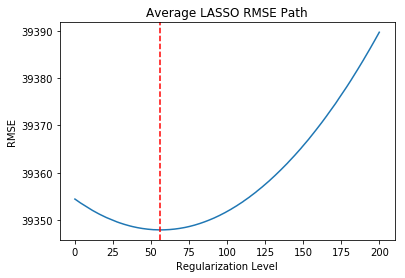

In [57]:
plt.plot(alphas, rmses)
plt.axvline(x=optimal_alpha, color='red', linestyle='dashed')
ax = plt.gca()
ax.set_title('Average LASSO RMSE Path')
ax.set_xlabel('Regularization Level')
ax.set_ylabel('RMSE')

### A simplified approach to Lasso and CV

Here we perform another L1-regularized regression but using `LassoCV`.  This is more in line with what we expect from you code-wise.  That being said, you should still understand the concepts from the previous section.

In [58]:
# Process the data
X_train, y_train = process_data_gm2(train)
X_test, y_test = process_data_gm2(test)

# Specify the model, alphas, and number of folds for CV
alphas = np.arange(0.1, 200.1, .1)
guidedmodel2 = lm.LassoCV(alphas=alphas, cv=5)

# Fit and predict
guidedmodel2.fit(X_train, y_train)
y_predicted = guidedmodel2.predict(X_test)

print(f'The validation RMSE for this model with '
      f'alpha={round(float(guidedmodel2.alpha_), 2)} is '
      f'{round(rmse(y_test, y_predicted), 2)}.')

The validation RMSE for this model with alpha=55.8 is 43511.9.


Again, we can map out the path that the Lasso algorithm took.

Text(0,0.5,'RMSE')

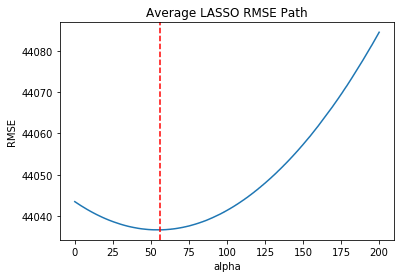

In [59]:
plt.plot(guidedmodel2.alphas_, np.sqrt(np.apply_along_axis(np.mean, 1, guidedmodel2.mse_path_)))
plt.axvline(x=optimal_alpha, color='red', linestyle='dashed')
ax = plt.gca()
ax.set_title('Average LASSO RMSE Path')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')

### Lasso Residual Plot

Looking at the residual plot for our L1 regularized linear model, it's clear the regularization did not solve the problems we saw in the simple model.  It seems you have your work cut out for you!

Text(0,0.5,'Residuals (Actual Price - Predicted Price)')

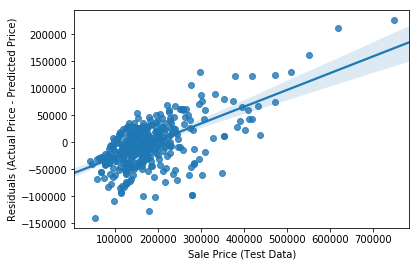

In [60]:
gm2_residuals = y_test - y_predicted
ax = sns.regplot(y_test, gm2_residuals)
ax.set_xlabel('Sale Price (Test Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')

# Open-Response

The second assignment is purposefully left nearly open-ended.  The Ames data in your possession comes from a larger data set.  Your goal is to provide a linear model (linear regression, Lasso, Ridge, or ElasticNet) that accurately predicts the prices of the held-out homes, measured by root mean square error.  That is, the score you will see on the Kaggle leaderboard is calculated as follows:

$$score = \sqrt{\dfrac{\sum_{\text{houses in public test set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{# of houses}}}$$

Perfect prediction of house prices would have a score of 0, so you want your score to be as low as possible!

**Kaggle Submission Site:** https://inclass.kaggle.com/c/ds100-s2018-hw6  
**Max number of submissions per day:** 2  
**Max number of final submissions:** 1 

### Grading Scheme

Your grade for the open-response section will be based on 4 things: your training RMSE, your public test set RMSE (seen on Kaggle), and your private test set RMSE (hidden until the end of the competition).  The thresholds are as follows:

#### RMSE
Points | 10 | 8 | 6 | 4 | 2 | 0
--- | --- | --- | --- | --- | --- | ---
Training RMSE | Less than 26k | 26k - 28k | 28k - 30k | 30k-35k | More than 35k | No work

Points | 10 | 8 | 6 | 4 | 2 | 0
--- | --- | --- | --- | --- | --- | ---
Public Test Set RMSE | Less than 27k | 27k - 30k | 30k - 33k | 33k-36k | More than 36k | No work

Points | 5 | 4 | 3 | 2 | 1 | 0
--- | --- | --- | --- | --- | --- | ---
Private Test Set RMSE | Less than 29k | 29k - 32k | 32k - 35k | 35k-38k | More than 38k | No work 

### Deliverables

#### Question 12 <a name="q12"></a>

Just as in the guided model above, you should encapsulate as much of your workflow into functions as possible.  Define `process_data_fm` and `final model` in the cell below.  In order to calculate your final model's RMSE, we will run the code in the cell after that.

**It is your duty to make sure that the code runs.** We will **NOT** accept regrade requests that require us to go back and run code that require typo/bug fixes. You can expect the data to be formatted like `ames_train.csv`.  `public_test_set.csv` and `private_test_set.csv` are both subsets of `ames_test.csv` (except that they both have the `SalePrice` column that was omitted from `ames_test.csv`).

### 1.Examing Correlation 
First we want to explore the correlation between each variable and the target -- housing price, and select those which are strongly correlated to it. From the table below, we can conclude that overall quality, general living area, garage area, total area of bathroom and the time when the house is built/sold are critical indicators of housing price.

In [61]:
corr_table = pd.DataFrame(full_data.corr()['SalePrice'])
corr_table.columns = ['Correlation']
corr_table.sort_values(by = 'Correlation', ascending = False).head(10)

,Correlation
SalePrice,1.000000
Overall_Qual,0.791354
Gr_Liv_Area,0.701277
Garage_Cars,0.652646
Garage_Area,0.644241
Total_Bsmt_SF,0.627223
1st_Flr_SF,0.621805
Year_Built,0.548391
Full_Bath,0.540014
Year_Remod/Add,0.535182


### 2. Feature engineering 
#### a. Ratio of total bedroom versus bathroom area

In [62]:
#return a new dataframe with a new column showing the ratio of total bedroom versus bathroom area.
def total_room_versus_bathroom(data):
    ratio = data['TotRms_AbvGrd']/add_total_bathrooms(data)['total_bathrooms']
    data['BedBath_Ratio'] = ratio
    return data

#### b. Garage


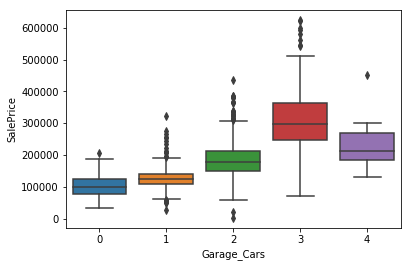

In [63]:
sns.boxplot(x=train['Garage_Cars'], y=train['SalePrice']);

We observe that something that doesn‘t make sense: 4-car carage should be more expensive instead of what shows in the graph above. Thus, it is important to remove those outliers. 

In [64]:
def garage(data):
    new = data.drop(data[(data['Garage_Cars']>3) & (data['SalePrice']< 300000)].index)
    return new

In [103]:
def categorical_clean(data): 
    data['Garage_Cond'] = data['Garage_Cond'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [5,4,3,2,1])
    data['Garage_Qual'] = data['Garage_Qual'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [5,4,3,2,1])
    data['Kitchen_Qual'] = data['Kitchen_Qual'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [5,4,3,2,1])
    data['Heating_QC'] = data['Heating_QC'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [5,4,3,2,1])
    data['Bsmt_Qual'] = data['Bsmt_Qual'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [5,4,3,2,1])
    data['Bsmt_Exposure'] = data['Bsmt_Exposure'].replace(['Gd', 'Av', 'Mn', 'No'], [4,3,2,1])
    data['BsmtFin_Type_1'] = data['BsmtFin_Type_1'].replace(['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf'], [6,5,4,3,2,1])
    data['Exter_Qual'] = data['Exter_Qual'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [5,4,3,2,1])
    data['Exter_Cond'] = data['Exter_Cond'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [5,4,3,2,1])
    data['Bsmt_Cond'] = data['Bsmt_Cond'].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [5,4,3,2,1])
    data['Central_Air'] = data['Central_Air'].replace(['Y', 'N'], (1,0))
    data['Pool_QC'] = data['Pool_QC'].replace(['Ex', 'Gd', 'TA', 'Fa'], [4,3,2,1])
    
    data['Garage_Cond'] = data['Garage_Cond'].fillna(0)
    data['Garage_Qual'] = data['Garage_Qual'].fillna(0)
    data['Bsmt_Qual'] = data['Bsmt_Qual'].fillna(0)
    data['Bsmt_Exposure'] = data['Bsmt_Exposure'].fillna(0)
    data['BsmtFin_Type_1'] = data['BsmtFin_Type_1'].fillna(0)
    data['Bsmt_Cond'] = data['Bsmt_Cond'].fillna(0)
    data['Pool_QC'] = data['Pool_QC'].fillna(0)
    

    
    return data

In [92]:
def ohe_Sale_Type(data):
    """
    One-hot-encodes Sale Sale Type.  New columns are of the form fpq_cats
    """
    cats = [
        'WD',
        'CWD',
        'VWD',
        'New',
        'COD',
        'Con',
        'ConLw',
        'ConLI',
        'ConLD',
        'Oth'
    ]

    cat_type = CategoricalDtype(categories=cats)
    data['Sale_Type'] = data['Sale_Type'].astype(cat_type)
    
    data = pd.get_dummies(data,
                          prefix='sale',
                          columns=['Sale_Type'], 
                          drop_first= False)
    
    return data

#### c. Year built & Year Remodel/add
we may want to take a look at the number of years since last remodel. If there never was one it would be since it was built.

In [67]:
def YearBuilt(data):
    year = (2018 - data['Year_Built']).tolist()
    data['YearBuilt'] = year
    return data

In [68]:
def YearRemodel(data):
    remodel = (2018 - data['Year_Remod/Add']).tolist()
    data['YearRemodel'] = remodel
    return data

#### d. Lot Area in general

In [69]:
lot = full_data[['Lot_Area','Lot_Config','Lot_Frontage','Lot_Shape']]
lot = pd.get_dummies(lot)
lot.corr()['Lot_Frontage']

Lot_Area              0.459863
Lot_Frontage          1.000000
Lot_Config_Corner     0.249518
Lot_Config_CulDSac   -0.121515
Lot_Config_FR2       -0.071121
Lot_Config_FR3        0.014133
Lot_Config_Inside    -0.141180
Lot_Shape_IR1         0.145207
Lot_Shape_IR2         0.017722
Lot_Shape_IR3         0.216290
Lot_Shape_Reg        -0.175644
Name: Lot_Frontage, dtype: float64

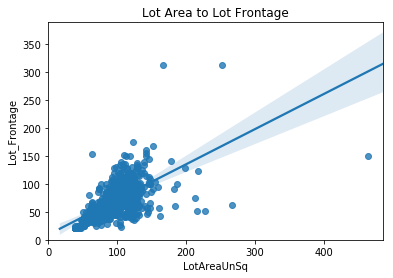

In [70]:
lot["LotAreaUnSq"] = np.sqrt(lot['Lot_Area'])
sns.regplot(x="LotAreaUnSq", y="Lot_Frontage", data=lot);
plt.xlim(0,)
plt.ylim(0,)
plt.title("Lot Area to Lot Frontage")
plt.show()

In [71]:
def Lot(data):
    lot = data[['Lot_Area','Lot_Config','Lot_Frontage','Lot_Shape']]
    lot = pd.get_dummies(lot)
    lot["LotAreaUnSq"] = np.sqrt(lot['Lot_Area'])
    lot = lot[lot['Lot_Frontage'].notnull()]
    data['Lot_Frontage']= data.Lot_Frontage.fillna(np.sqrt(data.Lot_Area))
    data['Lot_Frontage']= data['Lot_Frontage'].astype(int)
    return data

#### e. Total Area 

In [72]:
def totalSF(data):
    area = data['Total_Bsmt_SF'] + data['1st_Flr_SF'] + data['2nd_Flr_SF']
    data['TotalSF'] = area.tolist()
    return data

### 3. Modeling 

In [73]:
!pip install xgboost

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [119]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer 
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [129]:
def process_data_fm(data):
    
    # Clean Data
    data = remove_outliers(data, 'Gr_Liv_Area', upper= 5000)
    data = fix_fireplace_qu(data)
    
    #Add new features 
    data = add_total_bathrooms(data)
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    data = total_room_versus_bathroom(data)
    data = Lot(data)
    data = totalSF(data)
    data = categorical_clean(data)
    data = YearRemodel(data)
    data = select_columns(data,
                          'SalePrice', 
                          'total_bathrooms',
                          'Fireplace_Qu',
                          'Gr_Liv_Area',
                          'TotalSF',
                          'Kitchen_Qual',
                          'Overall_Cond',
                          'Overall_Qual',
                          'Year_Built',
                          'Exter_Qual',
                          'Exter_Cond',
                          'Mas_Vnr_Area',
                          'Bsmt_Exposure',
                          'Garage_Cond',
                          'Garage_Qual',
                          'Heating_QC',
                          'Central_Air',
                          'BsmtFin_Type_1',
                          'Bsmt_Cond',
                          'Open_Porch_SF',
                          'Bsmt_Qual',
                          'Pool_Area',
                          'in_rich_neighborhood'
                          )
    data = ohe_fireplace_qu(data)
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data['SalePrice']
    return X, y


# This needs to be an object with a fit and predict method
# The linear_model objects from sklearn all satisfy this
# e.g. final_model = lm.LinearRegression(fit_intercept=False)
final_model = XGBRegressor(learning_rate=0.1, num_boost_round = 17)

In [136]:
full_data = pd.read_csv('ames_train.csv')
train, test = train_test_split(full_data, test_size=0.2)
X_train, y_train = process_data_fm(train)
X_test, y_test = process_data_fm(test)


final_model.fit(X_train, y_train)
y_predicted = final_model.predict(X_test)

rmse(y_predicted, y_test)

25282.132170245593

## Hyperparameter tuning in XGBoost

In [81]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
}

In [82]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [84]:
params['subsample'] = .8
params['colsample_bytree'] = .9

In [85]:
%time

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


In [80]:
# training_data = pd.read_csv('ames_train.csv')
# public_test_data = pd.read_csv('public_test_set.csv')
# private_test_data = pd.read_csv('private_test_set.csv')

# X_train, y_train = process_data_fm(training_data)
# X_public, y_public = process_data_fm(public_test_data)
# X_private, y_private = process_data_fm(private_test_data)

# final_model.fit(X_train, y_train)
# y_predicted_train = final_model.predict(X_train)
# y_predicted_public = final_model.predict(X_public)
# y_predicted_private = final_model.predict(X_private)

# training_score = rmse(y_predicted_train, y_train)
# public_score = rmse(y_predicted_public, y_public)
# private_score = rmse(y_predicted_private, y_private)

In [76]:
# NO TOUCH

In [77]:
# NOH

In [78]:
# STAHP

In [79]:
# NO MOLESTE

In [80]:
# VA-T'EN

In [81]:
# NEIN

In [82]:
# PLSNO

In [83]:
# THIS SPACE IS NOT YOURS

In [84]:
# TAWDEETAW

In [85]:
# MAU LEN

In [86]:
# ALMOST

In [87]:
# TO

In [88]:
# THE

In [89]:
# END

In [90]:
# Hmph

In [91]:
# Good riddance

#### Question 13 <a name="q13"></a>

In addition, please submit one visualization from your EDA with 2-5 sentences describing why you thought the plot was interesting and what decisions it led to in your model specification.

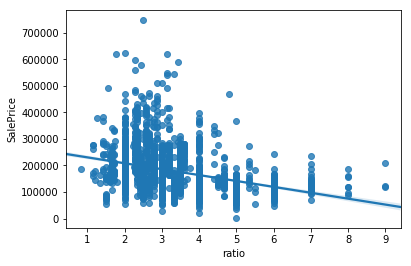

In [99]:
bath_data = add_total_bathrooms(full_data)
ratio = bath_data['TotRms_AbvGrd']/bath_data['total_bathrooms']
bath_data['ratio'] = ratio
sns.regplot(x="ratio", y="SalePrice", data=bath_data);

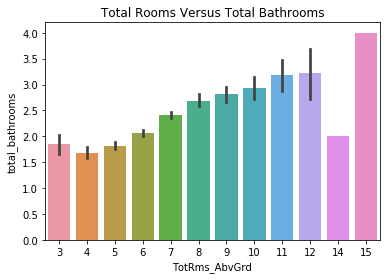

In [97]:
ax = sns.barplot(x="TotRms_AbvGrd", y="total_bathrooms",data= bath_data)
plt.title("Total Rooms Versus Total Bathrooms")
plt.show()

Commentary about your plot goes in the cell below.

The bar plot shows that there is a pronounce relationship between the number of total rooms and that of bathrooms. There is a positive correlation between the number of total rooms and that of bathrooms: the more total rooms a house has, the more bathrooms it has(except for the 14 tatal rooms which seems like a complete outlier from the data) From the scatter plot above, we can observe a negative correlation between the ratio of numbers of total bedrooms versus bathrooms and the saleprice. It seems like most of the pricey houses have a ratio of 3 or 2, meaning that the number of total bedrooms should be the three or two times of the number of bathrooms. 

### Submitting to Kaggle

The following code will write your predictions on the test dataset to a CSV, which you can submit to kaggle.  You may need to modify it a little to suit your needs.

In [92]:
GENERATE_SUBMISSION = False

In [84]:
GENERATE_SUBMISSION = True

In [85]:
from datetime import datetime

if GENERATE_SUBMISSION:
    
    test_data = pd.read_csv("ames_test.csv")
    X_test, y_test = process_data_fm(test_data)

    submission_df = pd.DataFrame(
        {
        "PID": test_data['PID'] , # This will come from ames_test.csv
        "SalePrice": final_model.predict(X_test) # This will come from your model
        }
    )

    timestamp = datetime.isoformat(datetime.now()).split(".")[0]

    submission_df.to_csv(f'submission_{timestamp}', index=False)

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/indexing.py:858: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_lowerdim(tup)


In [ ]:
from datetime import datetime

if GENERATE_SUBMISSION:
    
    test_data = pd.read_csv("ames_test.csv")

    submission_df = pd.DataFrame(
        {
        "PID": ..., # This will come from ames_test.csv
        "SalePrice": ... # This will come from your model
        }
    )

    timestamp = datetime.isoformat(datetime.now()).split(".")[0]

    submission_df.to_csv(f'submission_{timestamp}', index=False)